# 20220327-zoo-stats
- Cumulative statistics (weighted over simpoints)
    - Accuracy
    - Coverage
    - IPC improvement (over no prefetcher)
    - MPKI reduction (over no prefetcher)
    - DRAM bandwidth reduction (over no prefetcher)
- Collecting statistics (from `Pythia` directory):
    - Create Zoo sweep by running `./experiments/prefetcher_zoo.py condor_setup`
    - Evaluate Zoo sweep by running `./experiments/prefetcher_zoo.py eval`

In [243]:
from collections import defaultdict
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import display

from utils import utils, stats

from importlib import reload
reload(stats)
reload(utils)

<module 'utils.utils' from '/u/cmolder/GitHub/prefetching-zoo/utils/utils.py'>

In [244]:
weight_path = '/scratch/cluster/cmolder/traces/spec06/champsim/weights.txt'
weights = utils.read_weights_file(weight_path)

### Add SPEC results

In [245]:
# Individual prefetchers
path_spec = '/u/cmolder/GitHub/Pythia/out/prefetcher_zoo/2022_04_25_spec06/individual.csv'
df = utils.read_data_file(path_spec)

# Online PC-localized
# pta       :
# ptmu      :
# ptnu      : num_useful, invoke PC prefetchers only, register fill to all prefetchers
# ptnu_cred : num_useful, invoke all prefetchers, register fill to all prefetchers that prefetched address
path_online_pc_accuracy_spec = '/u/cmolder/GitHub/Pythia/out/prefetcher_zoo/2022_04_25_spec06/online_pc_accuracy.csv'
path_online_pc_coverage_spec = '/u/cmolder/GitHub/Pythia/out/prefetcher_zoo/2022_04_25_spec06/online_pc_coverage.csv'
path_online_pc_num_useful_spec = '/u/cmolder/GitHub/Pythia/out/prefetcher_zoo/2022_04_25_spec06/online_pc_num_useful.csv'
path_online_pc_marg_useful_spec = '/u/cmolder/GitHub/Pythia/out/prefetcher_zoo/2022_04_25_spec06/online_pc_marginal_useful.csv'
path_online_pc_num_useful_all_spec = '/u/cmolder/GitHub/Pythia/out/prefetcher_zoo/2022_04_25_spec06/online_pc_num_useful_all.csv'
path_online_pc_num_useful_cred_spec = '/u/cmolder/GitHub/Pythia/out/prefetcher_zoo/2022_04_25_spec06/online_pc_num_useful_credit.csv'

df_on_pta = utils.read_data_file(path_online_pc_accuracy_spec)
df_on_pta.LLC_pref = 'online_pc_acc'
df_on_pta.all_pref = [('no', 'no', 'online_pc_acc')]*len(df_on_pta)
df = df.append(df_on_pta)

df_on_ptc = utils.read_data_file(path_online_pc_coverage_spec)
df_on_ptc.LLC_pref = 'online_pc_cov'
df_on_ptc.all_pref = [('no', 'no', 'online_pc_cov')]*len(df_on_ptc)
df = df.append(df_on_ptc)

df_on_ptnu = utils.read_data_file(path_online_pc_num_useful_spec)
df_on_ptnu.LLC_pref = 'online_pc_num_useful'
df_on_ptnu.all_pref = [('no', 'no', 'online_pc_num_useful')]*len(df_on_ptnu)
df = df.append(df_on_ptnu)

df_on_ptmu = utils.read_data_file(path_online_pc_marg_useful_spec)
df_on_ptmu.LLC_pref = 'online_pc_marg_useful'
df_on_ptmu.all_pref = [('no', 'no', 'online_pc_marg_useful')]*len(df_on_ptmu)
df = df.append(df_on_ptmu)

df_on_ptnu_all = utils.read_data_file(path_online_pc_num_useful_all_spec)
df_on_ptnu_all.LLC_pref = 'online_pc_num_useful_all'
df_on_ptnu_all.all_pref = [('no', 'no', 'online_pc_num_useful_all')]*len(df_on_ptnu_all)
df = df.append(df_on_ptnu_all)

df_on_ptnu_cred = utils.read_data_file(path_online_pc_num_useful_cred_spec)
df_on_ptnu_cred.LLC_pref = 'online_pc_num_useful_credit'
df_on_ptnu_cred.all_pref = [('no', 'no', 'online_pc_num_useful_credit')]*len(df_on_ptnu_cred)
df = df.append(df_on_ptnu_cred)

# Offline PC-localized
path_offline_pc_accuracy_spec = '/u/cmolder/GitHub/Pythia/out/prefetcher_zoo/2022_04_25_spec06/offline_pc_accuracy.csv'
path_offline_pc_coverage_spec = '/u/cmolder/GitHub/Pythia/out/prefetcher_zoo/2022_04_25_spec06/offline_pc_coverage.csv'
path_offline_pc_num_useful_spec = '/u/cmolder/GitHub/Pythia/out/prefetcher_zoo/2022_04_25_spec06/offline_pc_num_useful.csv'
path_offline_pc_marg_useful_spec = '/u/cmolder/GitHub/Pythia/out/prefetcher_zoo/2022_04_25_spec06/offline_pc_marginal_useful.csv'

df_off_pta = utils.read_data_file(path_offline_pc_accuracy_spec)
df_off_pta.LLC_pref = 'offline_pc_acc'
df_off_pta.all_pref = [('no', 'no', 'offline_pc_acc')]*len(df_off_pta)
df = df.append(df_off_pta)

df_off_ptc = utils.read_data_file(path_offline_pc_coverage_spec)
df_off_ptc.LLC_pref = 'offline_pc_cov'
df_off_ptc.all_pref = [('no', 'no', 'offline_pc_cov')]*len(df_off_ptc)
df = df.append(df_off_ptc)

df_off_ptnu = utils.read_data_file(path_offline_pc_num_useful_spec)
df_off_ptnu.LLC_pref = 'offline_pc_num_useful'
df_off_ptnu.all_pref = [('no', 'no', 'offline_pc_num_useful')]*len(df_off_ptnu)
df = df.append(df_off_ptnu)

df_off_ptmu = utils.read_data_file(path_offline_pc_marg_useful_spec)
df_off_ptmu.LLC_pref = 'offline_pc_marg_useful'
df_off_ptmu.all_pref = [('no', 'no', 'offline_pc_marg_useful')]*len(df_off_ptmu)
df = df.append(df_off_ptmu)

### Add GAP results

In [246]:
# Individiual prefetchers
path_gap = '/u/cmolder/GitHub/Pythia/out/prefetcher_zoo/2022_04_25_gap/individual.csv'
df_gap = utils.read_data_file(path_gap)
df = df.append(df_gap)

# Online PC-localized
path_online_pc_accuracy_gap = '/u/cmolder/GitHub/Pythia/out/prefetcher_zoo/2022_04_25_gap/online_pc_accuracy.csv'
path_online_pc_coverage_gap = '/u/cmolder/GitHub/Pythia/out/prefetcher_zoo/2022_04_25_gap/online_pc_coverage.csv'
path_online_pc_num_useful_gap = '/u/cmolder/GitHub/Pythia/out/prefetcher_zoo/2022_04_25_gap/online_pc_num_useful.csv'
path_online_pc_marg_useful_gap = '/u/cmolder/GitHub/Pythia/out/prefetcher_zoo/2022_04_25_gap/online_pc_marginal_useful.csv'
path_online_pc_num_useful_all_gap = '/u/cmolder/GitHub/Pythia/out/prefetcher_zoo/2022_04_25_gap/online_pc_num_useful_all.csv'
path_online_pc_num_useful_cred_gap = '/u/cmolder/GitHub/Pythia/out/prefetcher_zoo/2022_04_25_gap/online_pc_num_useful_credit.csv'

df_on_pta = utils.read_data_file(path_online_pc_accuracy_gap)
df_on_pta.LLC_pref = 'online_pc_acc'
df_on_pta.all_pref = [('no', 'no', 'online_pc_acc')]*len(df_on_pta)
df = df.append(df_on_pta)

df_on_ptc = utils.read_data_file(path_online_pc_coverage_gap)
df_on_ptc.LLC_pref = 'online_pc_cov'
df_on_ptc.all_pref = [('no', 'no', 'online_pc_cov')]*len(df_on_ptc)
df = df.append(df_on_ptc)

df_on_ptnu = utils.read_data_file(path_online_pc_num_useful_gap)
df_on_ptnu.LLC_pref = 'online_pc_num_useful'
df_on_ptnu.all_pref = [('no', 'no', 'online_pc_num_useful')]*len(df_on_ptnu)
df = df.append(df_on_ptnu)

df_on_ptmu = utils.read_data_file(path_online_pc_marg_useful_gap)
df_on_ptmu.LLC_pref = 'online_pc_marg_useful'
df_on_ptmu.all_pref = [('no', 'no', 'online_pc_marg_useful')]*len(df_on_ptmu)
df = df.append(df_on_ptmu)

df_on_ptnu_all = utils.read_data_file(path_online_pc_num_useful_all_gap)
df_on_ptnu_all.LLC_pref = 'online_pc_num_useful_all'
df_on_ptnu_all.all_pref = [('no', 'no', 'online_pc_num_useful_all')]*len(df_on_ptnu_all)
df = df.append(df_on_ptnu_all)

df_on_ptnu_cred = utils.read_data_file(path_online_pc_num_useful_cred_gap)
df_on_ptnu_cred.LLC_pref = 'online_pc_num_useful_credit'
df_on_ptnu_cred.all_pref = [('no', 'no', 'online_pc_num_useful_credit')]*len(df_on_ptnu_cred)
df = df.append(df_on_ptnu_cred)

# Offline PC-localized
path_offline_pc_accuracy_gap = '/u/cmolder/GitHub/Pythia/out/prefetcher_zoo/2022_04_25_gap/offline_pc_accuracy.csv'
path_offline_pc_coverage_gap = '/u/cmolder/GitHub/Pythia/out/prefetcher_zoo/2022_04_25_gap/offline_pc_coverage.csv'
path_offline_pc_num_useful_gap = '/u/cmolder/GitHub/Pythia/out/prefetcher_zoo/2022_04_25_gap/offline_pc_num_useful.csv'
path_offline_pc_marg_useful_gap = '/u/cmolder/GitHub/Pythia/out/prefetcher_zoo/2022_04_25_gap/offline_pc_marginal_useful.csv'

df_off_pta = utils.read_data_file(path_offline_pc_accuracy_gap)
df_off_pta.LLC_pref = 'offline_pc_acc'
df_off_pta.all_pref = [('no', 'no', 'offline_pc_acc')]*len(df_off_pta)
df = df.append(df_off_pta)

df_off_ptc = utils.read_data_file(path_offline_pc_coverage_gap)
df_off_ptc.LLC_pref = 'offline_pc_cov'
df_off_ptc.all_pref = [('no', 'no', 'offline_pc_cov')]*len(df_off_ptc)
df = df.append(df_off_ptc)

df_off_ptnu = utils.read_data_file(path_offline_pc_num_useful_gap)
df_off_ptnu.LLC_pref = 'offline_pc_num_useful'
df_off_ptnu.all_pref = [('no', 'no', 'offline_pc_num_useful')]*len(df_off_ptnu)
df = df.append(df_off_ptnu)

df_off_ptmu = utils.read_data_file(path_online_pc_marg_useful_gap)
df_off_ptmu.LLC_pref = 'offline_pc_marg_useful'
df_off_ptmu.all_pref = [('no', 'no', 'offline_pc_marg_useful')]*len(df_off_ptmu)
df = df.append(df_off_ptmu)

### Add CloudSuite results

In [247]:
### Add CloudSuite results

# Individual prefetchers
path_cs = '/u/cmolder/GitHub/Pythia/out/prefetcher_zoo/2022_04_08_cloudsuite/individual.csv'
df_cs = utils.read_data_file(path_cs)
df = df.append(df_cs)

In [248]:
#pd.set_option('display.max_rows', 100)
#display(df[df.full_trace == 'astar_313B'])

---
## Helper functions

In [263]:
all_opportunity_prefetchers = [
    ('no', 'no', 'offline_phase'), 
    ('no', 'no', 'online_pc_acc'), 
    ('no', 'no', 'online_pc_cov'),
    ('no', 'no', 'online_pc_marg_useful'),
    ('no', 'no', 'online_pc_num_useful'),
    ('no', 'no', 'online_pc_num_useful_all'),
    ('no', 'no', 'online_pc_num_useful_credit'),
    ('no', 'no', 'offline_pc_acc'), 
    ('no', 'no', 'offline_pc_cov'),
    ('no', 'no', 'offline_pc_num_useful'),
    ('no', 'no', 'offline_pc_marg_useful'),
]

def _get_label(prefetcher, prefetcher_list=None, include_rank = True):
    if prefetcher in all_opportunity_prefetchers:
        #return ' '.join(prefetcher)
        return prefetcher[-1]
    elif include_rank: 
        #return f'({prefetcher_list.index(prefetcher)+1}) {" ".join(prefetcher)}' if prefetcher_list is not None else prefetcher   
        return f'({prefetcher_list.index(prefetcher)+1}) {prefetcher[-1]}' if prefetcher_list is not None else prefetcher[-1]
    else:
        return f'{prefetcher[-1]}' if prefetcher_list is not None else prefetcher[-1]
    
def _get_color(prefetcher):
    colors = {
        # Phase (Blue)
        ('no', 'no', 'offline_phase'): 'blue',
        # PC Online (Green)
        ('no', 'no', 'online_pc_acc'): 'darkgreen',
        ('no', 'no', 'online_pc_cov'): 'forestgreen',
        ('no', 'no', 'online_pc_marg_useful'): 'green',
        ('no', 'no', 'online_pc_num_useful'): 'limegreen',
        
        # PC Online+All (Purple)
        ('no', 'no', 'online_pc_num_useful_all'): 'purple',
        # PC Online+Credit (Yellow)
        ('no', 'no', 'online_pc_num_useful_credit'): 'gold',
        # PC Offline (Red)
        ('no', 'no', 'offline_pc_acc'): 'brown',
        ('no', 'no', 'offline_pc_cov'): 'indianred',
        ('no', 'no', 'offline_pc_marg_useful'): 'lightcoral',
        ('no', 'no', 'offline_pc_num_useful'): 'red',
        
    }
    if prefetcher in colors.keys():
        return colors[prefetcher]
    else: return None

def _get_hatch(prefetcher):
    hatches = {}
    # hatches = {
    #     ('no', 'no', 'offline_phase'): 'x',
    #     ('no', 'no', 'online_pc_acc'): '.',
    #     ('no', 'no', 'online_pc_cov'): '.',
    #     ('no', 'no', 'online_pc_num_useful'): '.',
    #     ('no', 'no', 'online_pc_marg_useful'): '.',
    #     ('no', 'no', 'online_pc_num_useful_all'): '.',
    #     ('no', 'no', 'online_pc_num_useful_credit'): '.',
    #     ('no', 'no', 'offline_pc_acc'): 'x',
    #     ('no', 'no', 'offline_pc_cov'): 'x',
    #     ('no', 'no', 'offline_pc_num_useful'): 'x',
    #     ('no', 'no', 'offline_pc_marg_useful'): 'x',
    # }
    if prefetcher in hatches.keys():
        return hatches[prefetcher]
    else: return None

def plot_cumulative_statistics(df, weights, metric='accuracy', method='weighted',
                               prefetchers=None,
                               opportunity_prefetchers=all_opportunity_prefetchers,
                               override_labels={},
                               override_colors={},
                               benchmarks=None,
                               dpi=192,
                               ymin=None, ymax=None):
    # Filter benchmarks
    if benchmarks is not None:
        df = df[df.trace.isin(benchmarks)]
        
    # Filter or weight simpoints  
    # Add phase_combined
    if method == 'weighted':
        df = stats.get_weighted_statistics(df, weights, add_phase_combined=True) # Weighted simpoints
    else:
        df = df[df.full_trace.isin(stats.get_longest_simpoints(weights))] # Longest simpoint
        
    # Filter prefetchers by weighted simpoints
    if prefetchers is not None:
        df = df[df.all_pref.isin(prefetchers + opportunity_prefetchers)]
    
    # Plot
    df = df.sort_values('trace',key=lambda col: col.str.lower())
    traces = df['trace'].unique()
    num_prefetchers = len(df.groupby('all_pref'))
    num_traces = len(df.groupby('trace'))
    mean_metric = 'amean' if metric in utils.amean_metrics else 'gmean'
    sep = 3
    
    fig, ax = plt.subplots(figsize=(14, 6), dpi=dpi)
    ax.grid(axis='y', color='lightgray')
    ax.axhline(0, color='black')
    ax.set_axisbelow(True)
    
    if prefetchers is not None:
        pf_list = prefetchers + opportunity_prefetchers
    else:
        pf_list = pd.unique(df[['L1D_pref', 'L2C_pref', 'LLC_pref']].values.ravel('K'))
    
    for i, pf in enumerate(pf_list):
        df_pf = df[df.all_pref == pf]
        y = df_pf[metric].to_numpy()
        y = np.append(y, utils.mean(y, metric))
        X = np.arange(0, len(y)) * (num_prefetchers + sep) + i
        label = override_labels[pf] if pf in override_labels else _get_label(pf, prefetchers)
        color = override_colors[pf] if pf in override_colors else _get_color(pf)
        ax.bar(X, y, label=label, color=color)
        
    ax.set_yticks(np.arange(ymin, ymax, 10))
    ax.set_xticks(np.arange(0, len(traces) + 1) * (num_prefetchers + sep) + (num_prefetchers)/2)
    ax.set_xticklabels(traces.tolist() + [mean_metric], rotation=45)
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')
    
    fig.suptitle(f'{metric} ({method} simpoint)')
    ax.set_xlabel('Trace')
    ax.set_ylabel(metric)
    ax.set_ylim(ymin=ymin, ymax=ymax) 
    fig.tight_layout()

In [264]:
def plot_everything(df, weights, 
                    prefetchers=None, 
                    opportunity_prefetchers=all_opportunity_prefetchers,
                    benchmarks=None,
                    dpi=None,
                    override_labels={},
                    override_colors={},
                    ipc_ymax=150,
                    save_suffix=''):
    # Accuracy
    plot_cumulative_statistics(df, weights, metric='LLC_accuracy', method='weighted',
                               prefetchers=prefetchers,
                               opportunity_prefetchers=opportunity_prefetchers,
                               benchmarks=benchmarks,
                               override_labels=override_labels,
                               override_colors=override_colors,
                               ymin=0, ymax=105, dpi=dpi)
    plt.savefig(f'plots/zoo-stats/accuracy{save_suffix}.pdf')
    
    # Coverage
    plot_cumulative_statistics(df, weights, metric='LLC_coverage', method='weighted',
                               prefetchers=prefetchers,
                               opportunity_prefetchers=opportunity_prefetchers,
                               benchmarks=benchmarks,
                               override_labels=override_labels,
                               override_colors=override_colors,
                               ymin=-20, ymax=105, dpi=dpi)
    plt.savefig(f'plots/zoo-stats/coverage{save_suffix}.pdf')
    
    # DRAM bandwidth reduction
    # plot_cumulative_statistics(df, weights, metric='dram_bw_reduction', method='weighted',
    #                            prefetchers=prefetchers,
    #                            opportunity_prefetchers=opportunity_prefetchers,
    #                            benchmarks=benchmarks,
    #                            ymin=-20, ymax=100, dpi=dpi)
    # plt.savefig(f'plots/zoo-stats/dram_bw_reduction{save_suffix}.pdf')
    
    # MPKI reduction
    plot_cumulative_statistics(df, weights, metric='LLC_mpki_reduction', method='weighted',
                               prefetchers=prefetchers,
                               opportunity_prefetchers=opportunity_prefetchers,
                               benchmarks=benchmarks,
                               override_labels=override_labels,
                               override_colors=override_colors,
                               ymin=-20, ymax=105, dpi=dpi)
    plt.savefig(f'plots/zoo-stats/mpki_reduction{save_suffix}.pdf')
    
    # IPC improvement
    plot_cumulative_statistics(df, weights, metric='ipc_improvement', method='weighted',
                               prefetchers=prefetchers,
                               opportunity_prefetchers=opportunity_prefetchers,
                               benchmarks=benchmarks,
                               override_labels=override_labels,
                               override_colors=override_colors,
                               ymin=-20, ymax=ipc_ymax, dpi=dpi)
    plt.savefig(f'plots/zoo-stats/ipc_improvement{save_suffix}.pdf')

---
# Mean statistics

In [251]:
def plot_mean_stats(df, weights, prefetchers, suites, suite_names,
                    metric='ipc_improvement',
                    override_labels={},
                    override_colors={},
                    override_hatches={},
                    dpi=None):
    fig, ax = plt.subplots(dpi=dpi)
    ax.grid(axis='y', color='lightgray')
    ax.set_axisbelow(True)
    
    # Filter benchmarks
    df = df[df.trace.isin(itertools.chain.from_iterable(suites))]
        
    # Filter or weight simpoints  
    # Add phase_combined
    df = stats.get_weighted_statistics(df, weights, add_phase_combined=True) # Weighted simpoints
    
    # Plot
    df = df.sort_values('trace',key=lambda col: col.str.lower())
    traces = df['trace'].unique()
    num_prefetchers = len(df.groupby('all_pref'))
    num_traces = len(df.groupby('trace'))
    mean_metric = 'amean' if metric in utils.amean_metrics else 'gmean'
    
    suite_sep = 3
    suite_width = len(prefetchers)
    
    for i, (suite_name, suite) in enumerate(zip(suite_names, suites)):
        df_suite = df[df.trace.isin(suite)]
        for j, pf in enumerate(prefetchers):
            df_pref = df_suite[df_suite.all_pref == pf]
            
            X = i*(suite_width + suite_sep) + j
            mean = utils.mean(df_pref[metric], metric)
                
            label = override_labels[pf] if pf in override_labels else _get_label(pf, prefetchers)
            color = override_colors[pf] if pf in override_colors else _get_color(pf)
            hatch = override_hatches[pf] if pf in override_hatches else _get_hatch(pf)
            
            
            #print(label, color)
            ax.bar(
                X, mean, 
                label=label if i == 0 else None,
                color=color if color is not None else f'C{j}',
                hatch=hatch,
            )
    
    metric = metric.replace('_', ' ')
    ax.set_xticks(np.arange(len(suites)) * (suite_sep+suite_width) + (suite_width/2) - 0.5)
    ax.set_xticklabels(suite_names)
    ax.set_xlabel('Suite')
    ax.set_ylabel(metric + ' (%)')
    ax.set_ylim(ymin=0, ymax=100)
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')
    fig.suptitle(f'{metric} {mean_metric} (weighted simpoint)')
    fig.tight_layout()

### Top 5 hybrids (overall) by IPC improvement

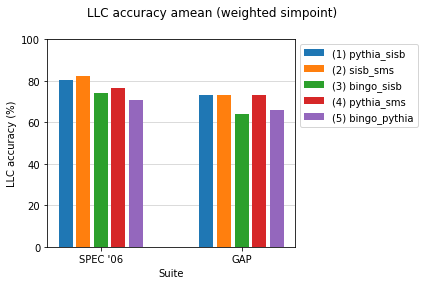

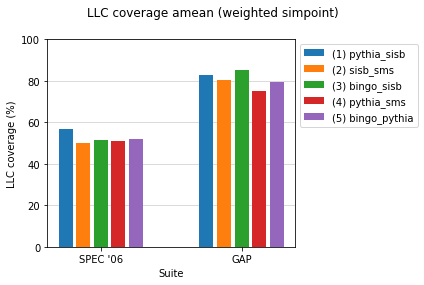

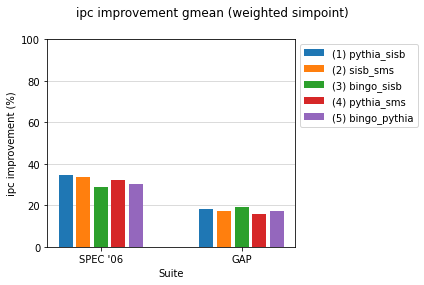

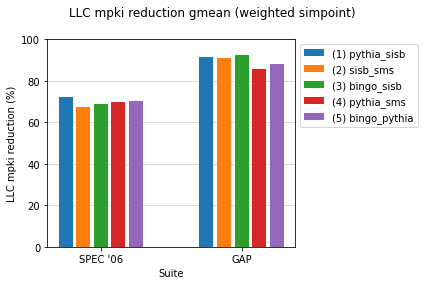

In [252]:
dpi = None
overall_top_5 = utils.rank_prefetchers(df, 'ipc_improvement', 5)

for metric in ['LLC_accuracy', 'LLC_coverage', 'ipc_improvement', 'LLC_mpki_reduction']:
    plot_mean_stats(
        df, weights, overall_top_5, [utils.spec, utils.gap], ['SPEC \'06', 'GAP'],
        metric=metric,
        dpi=dpi
    )
    plt.savefig(f'plots/zoo-stats/{metric}_means.pdf')

### PC-localized metrics + best hybrid + best single

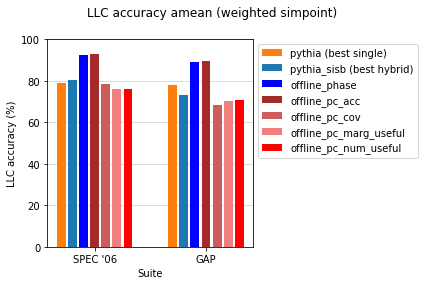

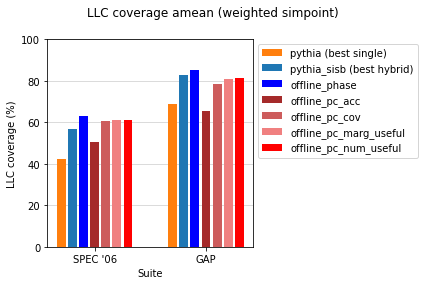

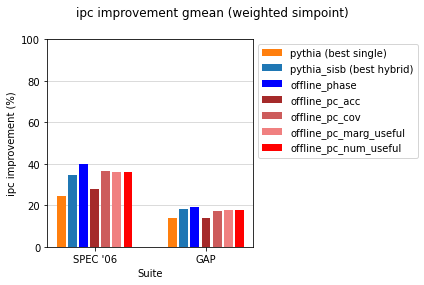

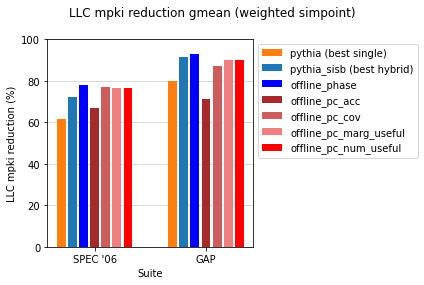

In [253]:
dpi = None
best_single = utils.rank_single_prefetchers(df, 'ipc_improvement', 1)
best_hybrid = utils.rank_prefetchers(df, 'ipc_improvement', 1)
opp_prefs = [
    ('no', 'no', 'offline_phase'),
    ('no', 'no', 'offline_pc_acc'),
    ('no', 'no', 'offline_pc_cov'),
    ('no', 'no', 'offline_pc_marg_useful'),
    ('no', 'no', 'offline_pc_num_useful'),
    
]

prefs = list(itertools.chain.from_iterable((best_single, best_hybrid, opp_prefs)))
for metric in ['LLC_accuracy', 'LLC_coverage', 'ipc_improvement', 'LLC_mpki_reduction']:
    plot_mean_stats(
        df, weights, prefs, [utils.spec, utils.gap], ['SPEC \'06', 'GAP'],
        metric=metric,
        override_labels={
            ('no', 'no', 'pythia'): 'pythia (best single)',
            ('no', 'no', 'pythia_sisb'): 'pythia_sisb (best hybrid)'
        },
        override_colors={
            ('no', 'no', 'pythia'): 'C1',
            ('no', 'no', 'pythia_sisb'): 'C0'
        },
        dpi=dpi
    )
    plt.savefig(f'plots/zoo-stats/{metric}_means_opportunity_pcmetric.pdf')

### Opportunity prefetchers + best hybrid + best single

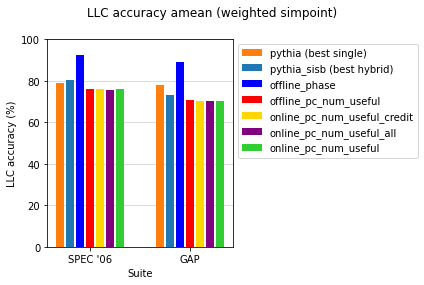

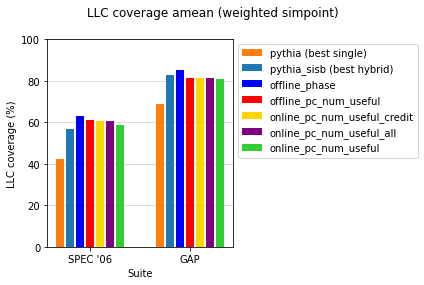

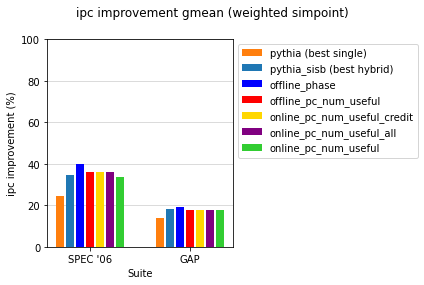

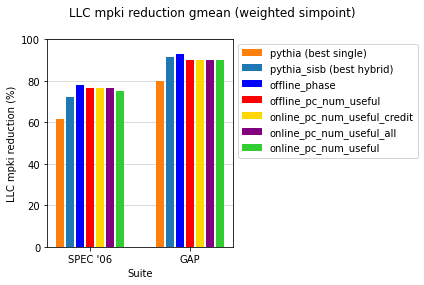

In [254]:
dpi = None
best_single = utils.rank_single_prefetchers(df, 'ipc_improvement', 1)
best_hybrid = utils.rank_prefetchers(df, 'ipc_improvement', 1)
opp_prefs = [
    ('no', 'no', 'offline_phase'),
    ('no', 'no', 'offline_pc_num_useful'),
    ('no', 'no', 'online_pc_num_useful_credit'),
    ('no', 'no', 'online_pc_num_useful_all'),
    ('no', 'no', 'online_pc_num_useful'),
]

prefs = list(itertools.chain.from_iterable((best_single, best_hybrid, opp_prefs)))
for metric in ['LLC_accuracy', 'LLC_coverage', 'ipc_improvement', 'LLC_mpki_reduction']:
    plot_mean_stats(
        df, weights, prefs, [utils.spec, utils.gap], ['SPEC \'06', 'GAP'],
        metric=metric,
        override_labels={
            ('no', 'no', 'pythia'): 'pythia (best single)',
            ('no', 'no', 'pythia_sisb'): 'pythia_sisb (best hybrid)'
        },
        override_colors={
            ('no', 'no', 'pythia'): 'C1',
            ('no', 'no', 'pythia_sisb'): 'C0'
        },
        dpi=dpi
    )
    plt.savefig(f'plots/zoo-stats/{metric}_means_opportunity.pdf')

---
## SPEC '06 per-trace statistics

### Top 5 hybrids by IPC improvement

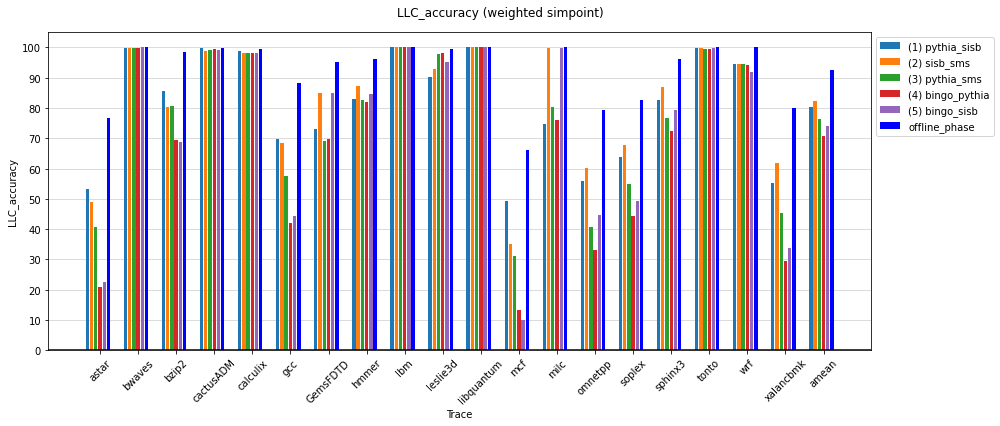

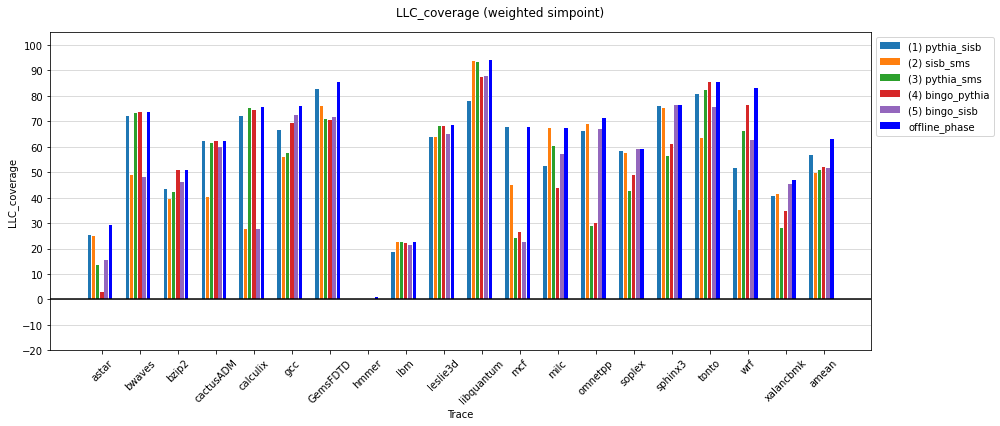

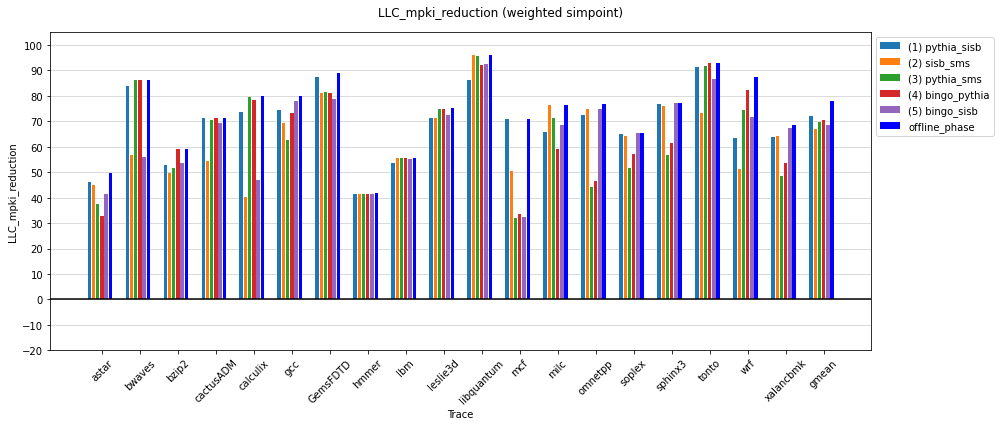

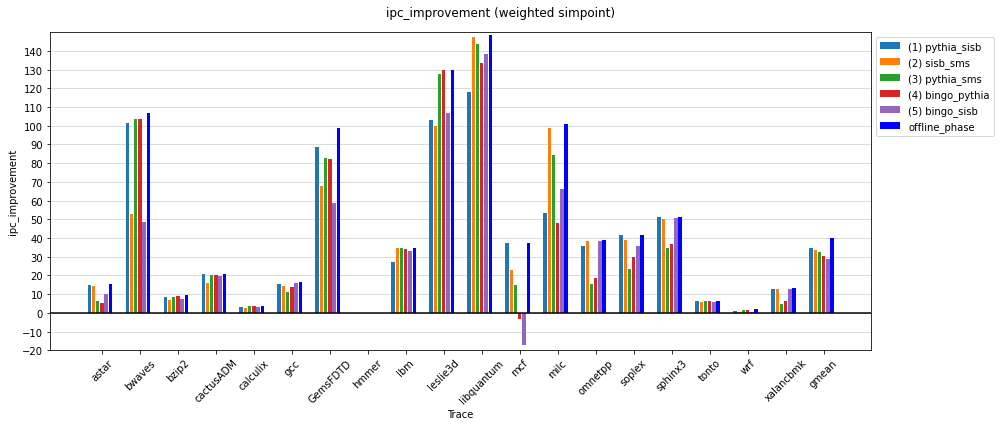

In [265]:
spec_top_5 = utils.rank_prefetchers(df[df.trace.isin(utils.spec)], 'ipc_improvement', 5)
opp_pref = [('no', 'no', 'offline_phase')]
dpi=None

plot_everything(
    df, weights, 
    prefetchers=spec_top_5, 
    opportunity_prefetchers=opp_pref,
    benchmarks=utils.spec, dpi=dpi,
    save_suffix='_5_spec'
)

### Opportunity prefetchers

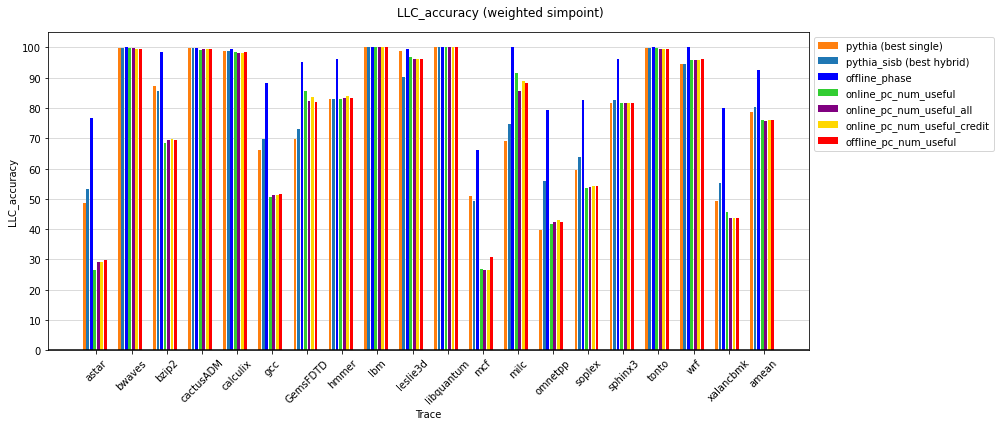

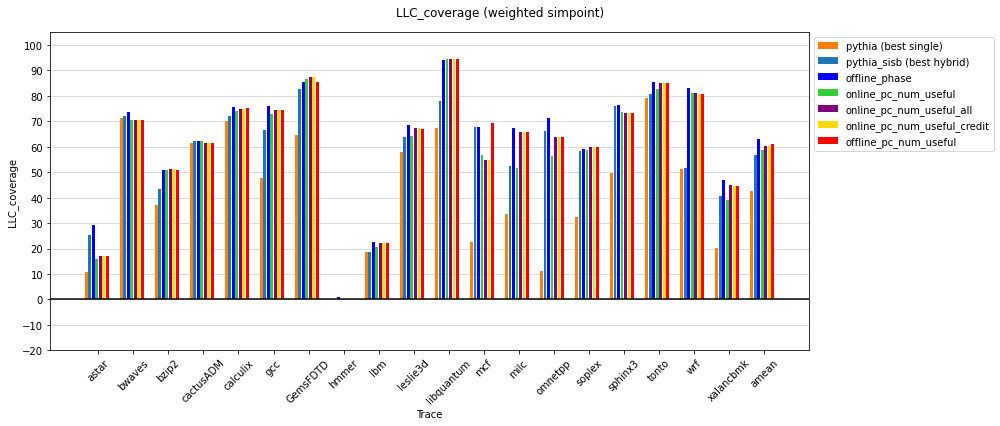

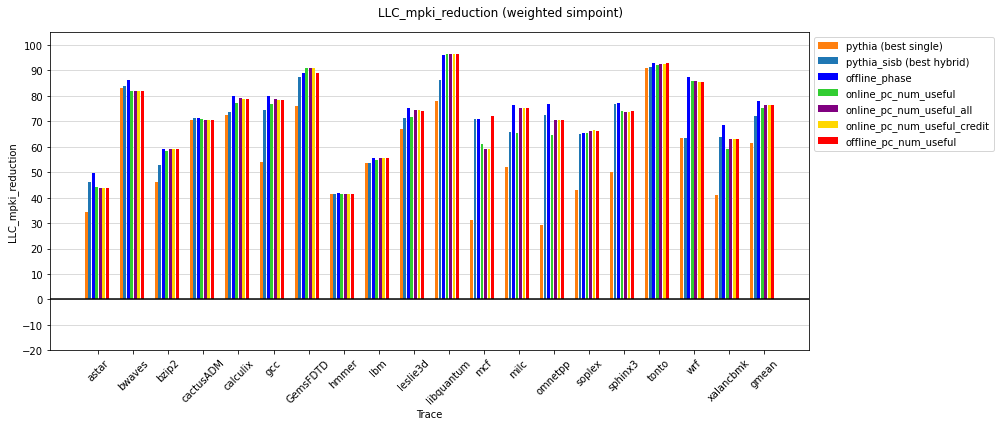

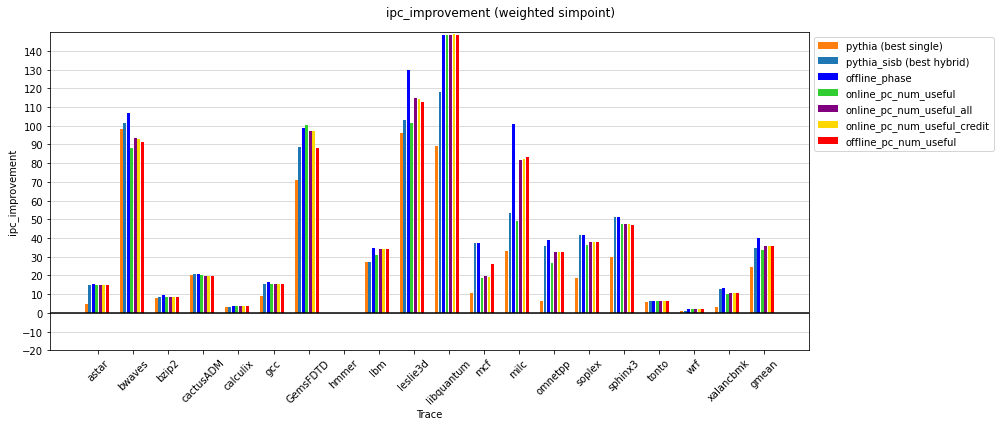

In [266]:
opp_prefs = [
    ('no', 'no', 'offline_phase'), 
    #('no', 'no', 'online_pc_acc'), 
    #('no', 'no', 'online_pc_cov'),
    #('no', 'no', 'online_pc_marg_useful'),
    ('no', 'no', 'online_pc_num_useful'),
    ('no', 'no', 'online_pc_num_useful_all'),
    ('no', 'no', 'online_pc_num_useful_credit'),
    #('no', 'no', 'offline_pc_acc'), 
    #('no', 'no', 'offline_pc_cov'),
    ('no', 'no', 'offline_pc_num_useful'),
    #('no', 'no', 'offline_pc_marg_useful'),
]
best_single = utils.rank_single_prefetchers(df[df.trace.isin(utils.spec)], 'ipc_improvement', 1)
best_hybrid = utils.rank_prefetchers(df[df.trace.isin(utils.spec)], 'ipc_improvement', 1)
prefs = list(itertools.chain.from_iterable((best_single, best_hybrid)))
dpi = None


plot_everything(
    df, weights, 
    prefetchers=prefs,
    opportunity_prefetchers=opp_prefs,
    benchmarks=utils.spec, dpi=dpi,
    override_labels={
        ('no', 'no', 'pythia'): 'pythia (best single)',
        ('no', 'no', 'pythia_sisb'): 'pythia_sisb (best hybrid)'
    },
    override_colors={
        ('no', 'no', 'pythia'): 'C1',
        ('no', 'no', 'pythia_sisb'): 'C0'
    },
    save_suffix='_opportunity_spec'
)

---
## GAP per-trace statistics

### Top 5 by IPC improvement
- Note: Weighted vs. longest simpoint doesn't matter here, since all gap traces are single-simpoint.

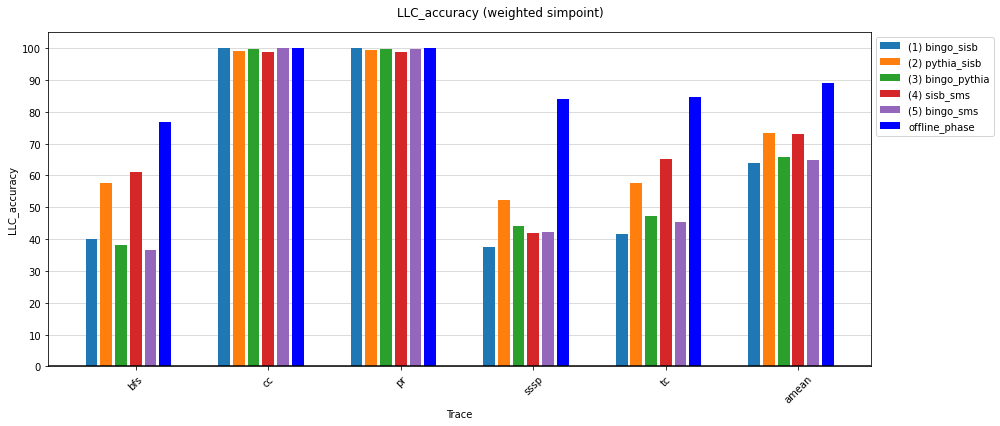

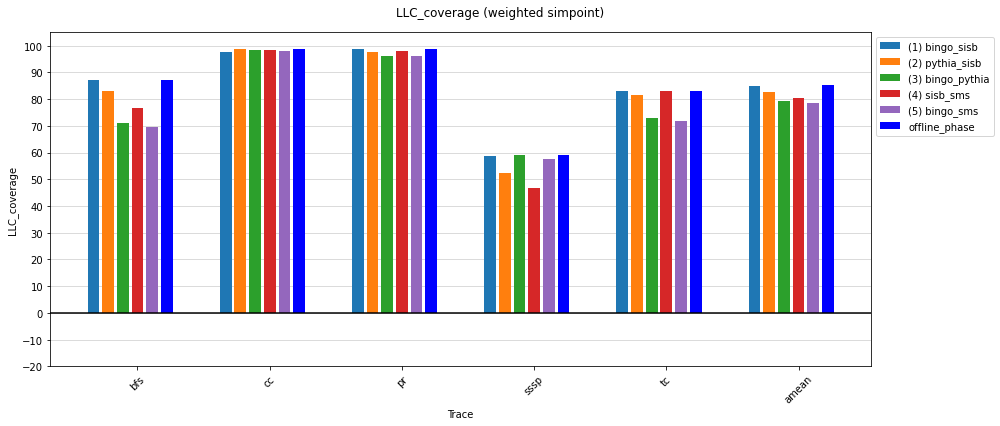

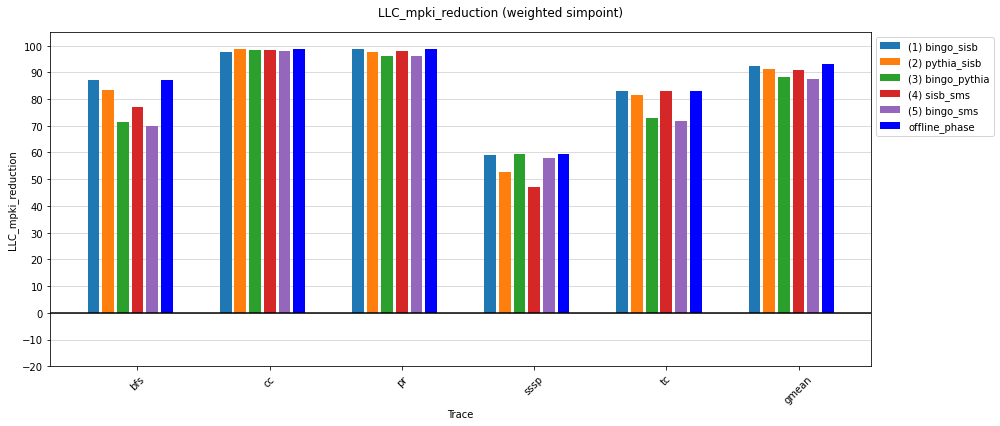

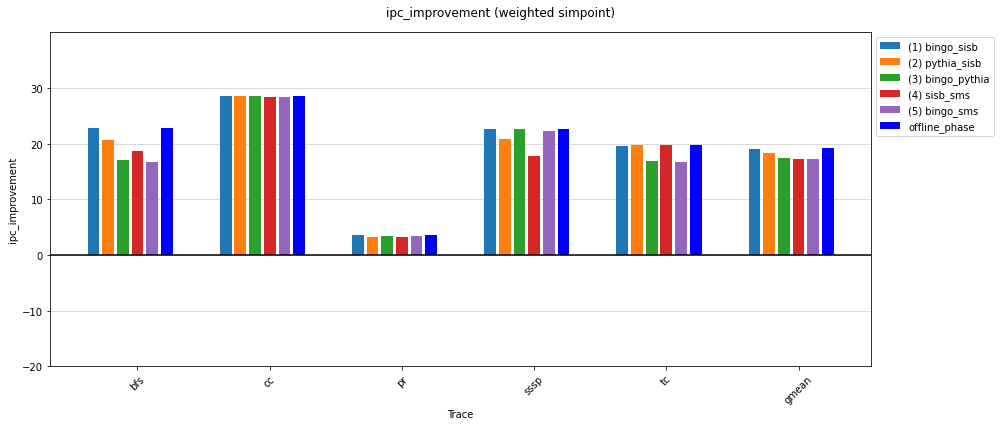

In [257]:
gap_top_5 = utils.rank_prefetchers(df[df.trace.isin(utils.gap)], 'ipc_improvement', 5)
opp_pref = [('no', 'no', 'offline_phase')]
dpi = None
plot_everything(
    df, weights, 
    prefetchers=gap_top_5, 
    opportunity_prefetchers=opp_pref,
    benchmarks=utils.gap, dpi=dpi,
    save_suffix='_5_gap',
    ipc_ymax=40
)

### Opportunity prefetchers

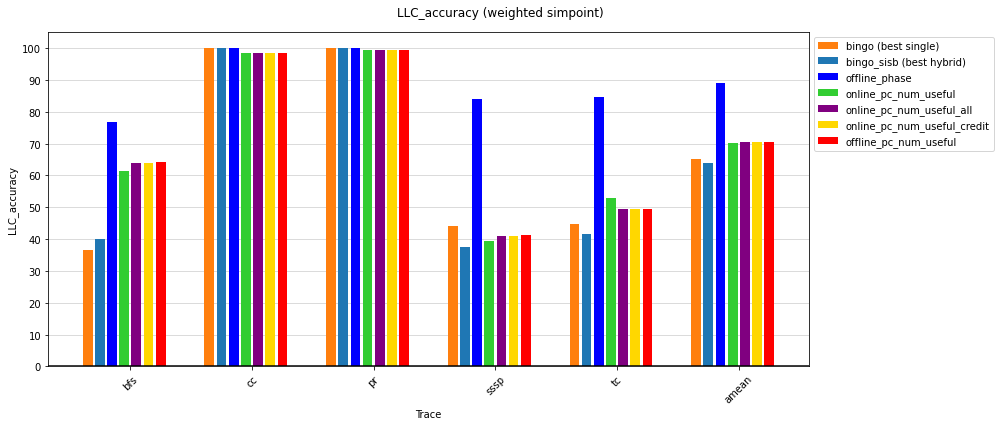

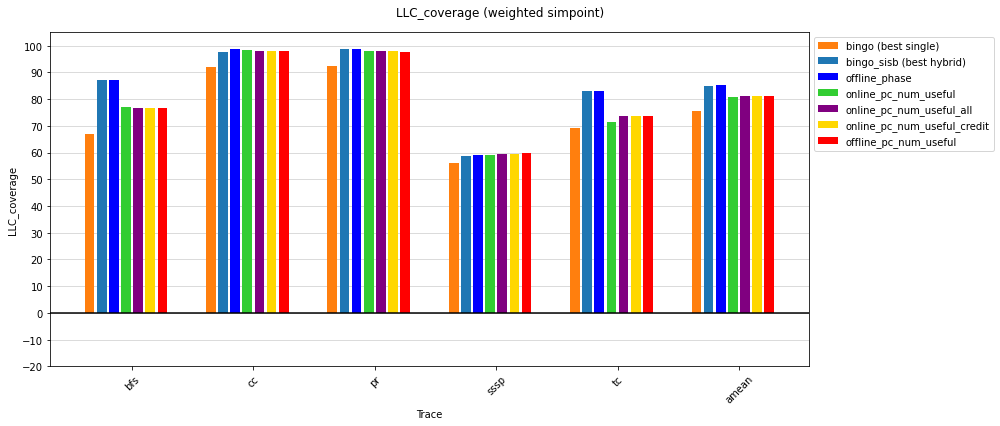

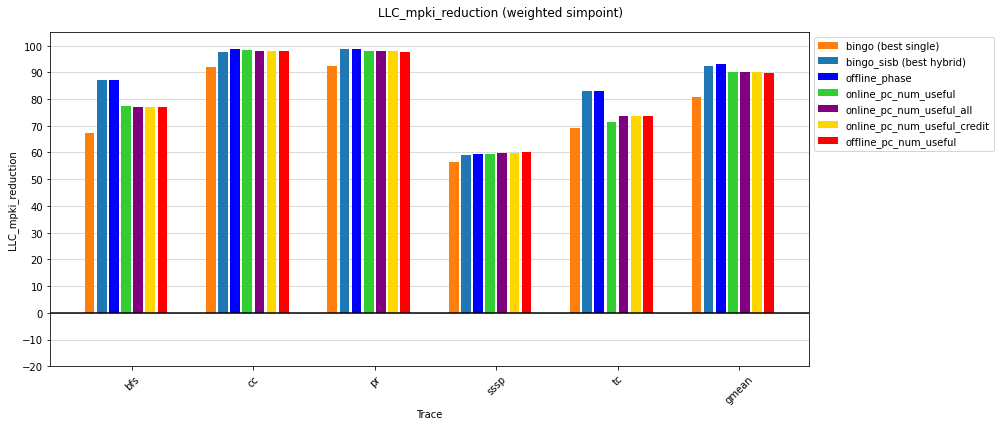

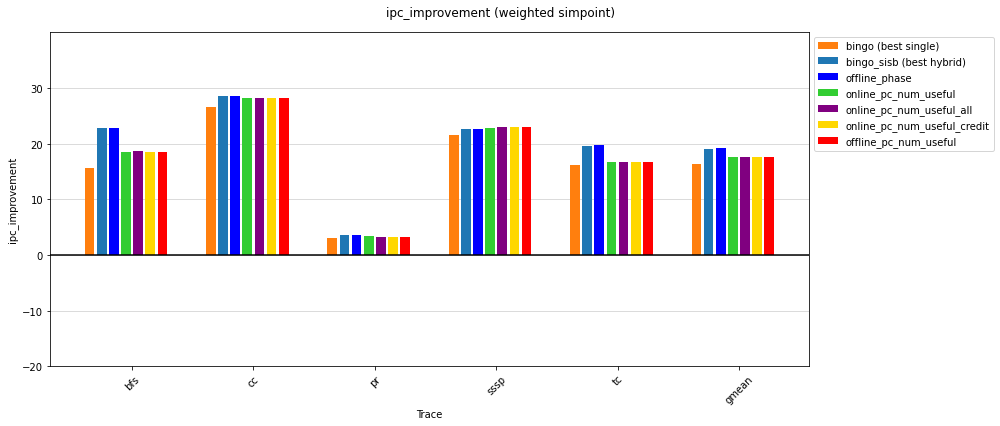

In [267]:
opp_prefs = [
    ('no', 'no', 'offline_phase'), 
    #('no', 'no', 'online_pc_acc'), 
    #('no', 'no', 'online_pc_cov'),
    #('no', 'no', 'online_pc_marg_useful'),
    ('no', 'no', 'online_pc_num_useful'),
    ('no', 'no', 'online_pc_num_useful_all'),
    ('no', 'no', 'online_pc_num_useful_credit'),
    #('no', 'no', 'offline_pc_acc'), 
    #('no', 'no', 'offline_pc_cov'),
    ('no', 'no', 'offline_pc_num_useful'),
    #('no', 'no', 'offline_pc_marg_useful'),
]
best_single = utils.rank_single_prefetchers(df[df.trace.isin(utils.gap)], 'ipc_improvement', 1)
best_hybrid = utils.rank_prefetchers(df[df.trace.isin(utils.gap)], 'ipc_improvement', 1)
prefs = list(itertools.chain.from_iterable((best_single, best_hybrid)))
dpi = None

plot_everything(
    df, weights, 
    prefetchers=prefs,
    opportunity_prefetchers=opp_prefs,
        override_labels={
        ('no', 'no', 'bingo'): 'bingo (best single)',
        ('no', 'no', 'bingo_sisb'): 'bingo_sisb (best hybrid)'
    },
    override_colors={
        ('no', 'no', 'bingo'): 'C1',
        ('no', 'no', 'bingo_sisb'): 'C0'
    },
    benchmarks=utils.gap, dpi=dpi,
    save_suffix='_opportunity_gap',
    ipc_ymax=40
)

---
## CloudSuite per-trace (per-core) statistics

### Top 5 by IPC improvement

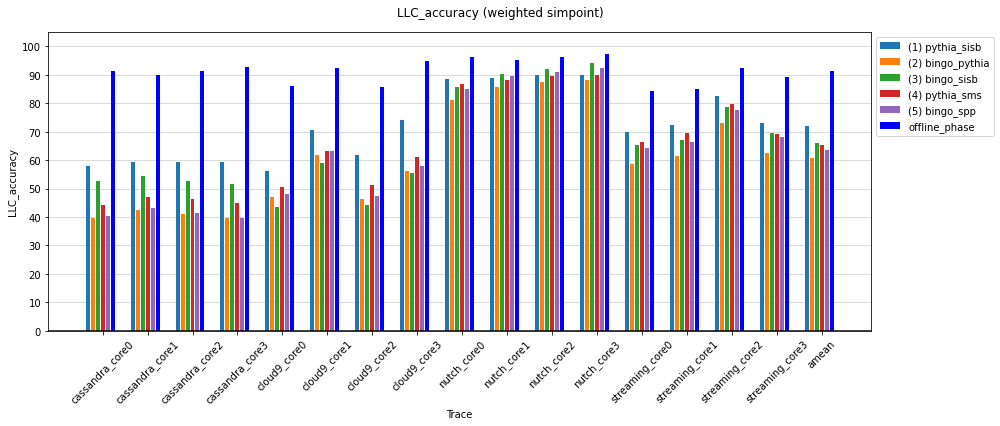

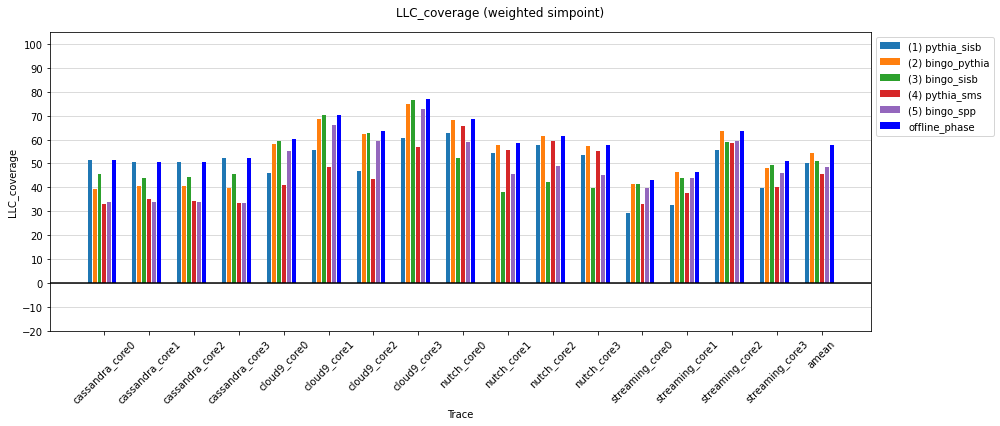

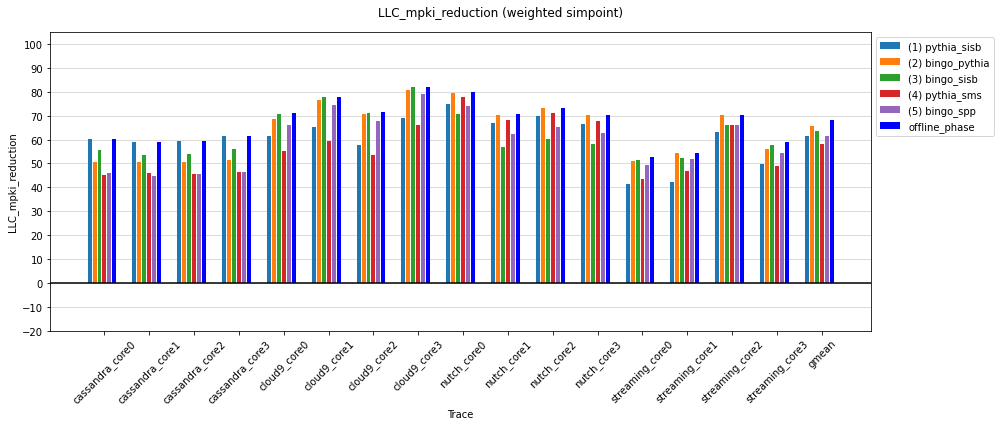

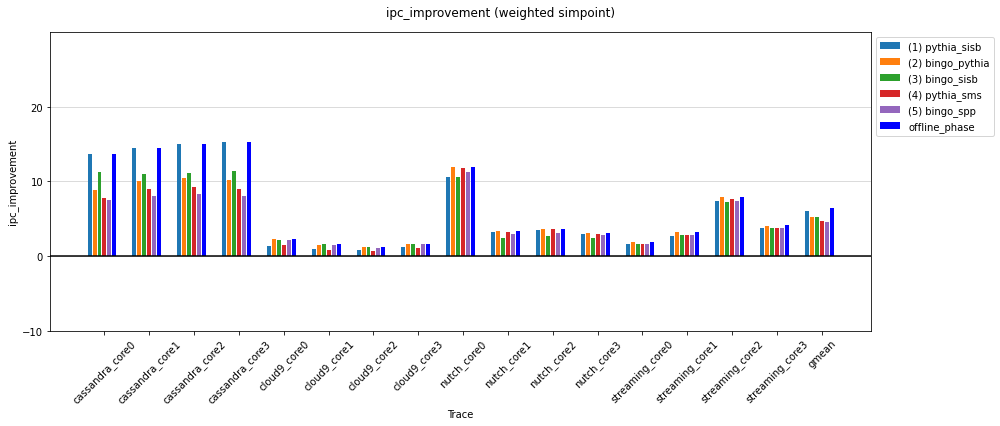

In [259]:
cs_top_5 = utils.rank_prefetchers(df[df.trace.isin(utils.cloudsuite)], 'ipc_improvement', 5)
opp_pref = [('no', 'no', 'offline_phase')]
dpi = None

# Accuracy
plot_cumulative_statistics(df, weights, metric='LLC_accuracy', method='weighted',
                           prefetchers=cs_top_5,
                           opportunity_prefetchers=opp_pref,
                           benchmarks=utils.cloudsuite,
                           ymin=0, ymax=105, dpi=dpi)

# Coverage
plot_cumulative_statistics(df, weights, metric='LLC_coverage', method='weighted',
                           prefetchers=cs_top_5,
                           opportunity_prefetchers=opp_pref,
                           benchmarks=utils.cloudsuite,
                           ymin=-20, ymax=105, dpi=dpi)

# MPKI reduction
plot_cumulative_statistics(df, weights, metric='LLC_mpki_reduction', method='weighted',
                           prefetchers=cs_top_5,
                           opportunity_prefetchers=opp_pref,
                           benchmarks=utils.cloudsuite,
                           ymin=-20, ymax=105, dpi=dpi)
plt.savefig('plots/zoo-stats/mpki_reduction_5_cloudsuite.pdf')

# DRAM bw reduction
# plot_cumulative_statistics(df, weights, metric='dram_bw_reduction', method='weighted',
#                            prefetchers=cs_top_5,
#                            opportunity_prefetchers=opp_pref,
#                            benchmarks=utils.cloudsuite,
#                            ymin=-60, ymax=60, dpi=dpi)
# plt.savefig('plots/zoo-stats/dram_bw_reduction_5_cloudsuite.pdf')

# IPC improvement
plot_cumulative_statistics(df, weights, metric='ipc_improvement', method='weighted',
                           prefetchers=cs_top_5,
                           opportunity_prefetchers=opp_pref,
                           benchmarks=utils.cloudsuite,
                           ymin=-10, ymax=30, dpi=dpi)
plt.savefig('plots/zoo-stats/ipc_improvement_5_cloudsuite.pdf')